# Facebook chat analysis

Some of our goals:
* map activity over time
* map who speaks more or lless
* word cloud
* basic sentiment analysis

# 1) Parsing chat logs into a pandas dataframe

In [43]:
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np

#put the paths of YOUR facebook chat log html files in this list. That's all that's required.
list_of_file_paths = [
                    'sample_input/messages_1.html',
                    'sample_input/messages_2.html'
                ]

#the sample chats are just random lines from Paradise Lost, formatted as a Facebook chat.

### Define functions for parsing a list of html files into a pandas dataframe

In [44]:
def html2Soup(filepath):
    with open(filepath, 'r') as f:
        s = f.read()
    
    soup = BeautifulSoup(s, "html") #we always use that format
    return soup

def messagesFile2DF(soup):
    """Given a BeautifulSoup of a Faebook chat archive html file, returns a dataframe with the messages loaded in"""
    
    #FOR NOW ONLY GET FIRST N, FOR PRACTICE
    textbody = soup.find_all('div', 
                              {'pam _3-95 _2pi0 _2lej uiBoxWhite noborder'})[1:] #returns LIST of these boxes. Each corresponds to one message
    
    #As recommended by Pandas, we build each list of items separately, then combine at the end into a dataframe.
    
    
    #We create empty lists for each message's author, date, and message. Each should line up exactly.
    author_fields = [None]*len(textbody)
    date_fields = [None]*len(textbody)
    message_fields = [None]*len(textbody)
    
    for index, section in enumerate(textbody):
        #get message
        try:
            message = section.find('div', {"_3-96 _2let"}).get_text()
        except:
            message = ""
        
        #get author
        try:
            author = section.find('div', {"_3-96 _2pio _2lek _2lel"}).get_text()
        except:
            author = ""
            #print("No author at index", index)
    
        #get date
        try:
            date = section.find('div', {"_3-94 _2lem"}).get_text()
        except:
            date = ""
            #print("No date at index", index)
        
        #record author, date, and message in appropriate location in the relevant lists
        author_fields[index] = author
        date_fields[index] = date
        message_fields[index] = message
        
        
    #create dataframe with this information
    messages_dataframe = pd.DataFrame({"Author" : author_fields, 
                                       "Date" : date_fields,
                                       "Message" : message_fields})
        
    return messages_dataframe

def fileList2DF(file_list):
    """For list of html file paths, returns a single merged data frame"""
    souplist = [html2Soup(path) for path in file_list]
    df_list = [messagesFile2DF(soup) for soup in souplist]
    df_merged = pd.concat(df_list, ignore_index = True)
    return df_merged


### Import and parse the HTML files

Replace the list of file paths with a list of html files corresponding to your chat or group chat. See ReadMe for instructions on how to do this.

In [45]:
merger = fileList2DF(list_of_file_paths)

#preview our table
merger


,Author,Date,Message
0,Mickey Mouse,"Apr 19, 2020, 5:17 AM",Whose wanton passions in the sacred proch
1,Donald Duck,"Apr 19, 2020, 5:12 AM","In th' arctic sky, and from his horrid hair"
2,Donald Duck,"Apr 19, 2020, 5:11 AM",With what all Earth or Heaven could bestow
3,Donald Duck,"Apr 19, 2020, 5:11 AM","Of Sun! to tell thee how I hate thy beams,"
4,Donald Duck,"Apr 19, 2020, 5:02 AM",To which the Hell I suffer seems a Heaven.
...,...,...,...
19995,Other,"Feb 17, 2016, 4:15 PM",And thus with words not sad she him received.
19996,William Shakespeare,"Feb 17, 2016, 4:15 PM",Or of the Eternal coeternal beam
19997,William Shakespeare,"Feb 17, 2016, 4:14 PM","Of proud ambitious heart; who, not content"
19998,Other,"Feb 17, 2016, 4:14 PM","Not obvious, not obtrusive, but, retired,"


### Save the resulting dataframe as a .csv file -- so you don't have to keep parsing it.

In [46]:
#change filename as desired

merger.to_csv("csv/chat_dataframe.csv")


### Re-import dataframe from csv
Leave Code above this untouched.

Instead, we re-import the data from our CSV, as a "fresh start" of sorts.

In [47]:
df = pd.read_csv("csv/chat_dataframe.csv")
del df["Unnamed: 0"]

In [48]:
#inspect
df

,Author,Date,Message
0,Mickey Mouse,"Apr 19, 2020, 5:17 AM",Whose wanton passions in the sacred proch
1,Donald Duck,"Apr 19, 2020, 5:12 AM","In th' arctic sky, and from his horrid hair"
2,Donald Duck,"Apr 19, 2020, 5:11 AM",With what all Earth or Heaven could bestow
3,Donald Duck,"Apr 19, 2020, 5:11 AM","Of Sun! to tell thee how I hate thy beams,"
4,Donald Duck,"Apr 19, 2020, 5:02 AM",To which the Hell I suffer seems a Heaven.
...,...,...,...
19995,Other,"Feb 17, 2016, 4:15 PM",And thus with words not sad she him received.
19996,William Shakespeare,"Feb 17, 2016, 4:15 PM",Or of the Eternal coeternal beam
19997,William Shakespeare,"Feb 17, 2016, 4:14 PM","Of proud ambitious heart; who, not content"
19998,Other,"Feb 17, 2016, 4:14 PM","Not obvious, not obtrusive, but, retired,"


# 2) Cleaning and improving the data

### Marking 'computer messages' as such:

A lot of messages in this group are actually not things that were said. These should probably not be considered in any data analysis. We will mark them as what they are.

If they are computer messages, it will say "computer message" in a new "message notes" column

In [49]:
#Identify kinds of "computer" messages that aren't really messages
known_computer_messages = {"joined the video chat", "changed the chat theme", 
                           "changed the group photo", "the group name", 
                           "named the group", "set the nickname",
                          "started a video chat", "set the emoji",
                          "own nickname", "from the group",
                          "chat ended"} #"Added ... to the group" is also hand-coded below

In [50]:
#find computer-generated messages with "joined the" video call and so on. note this informationin a new column.

messagelabels = [None] * len(df["Message"])

for index, message in enumerate(df["Message"]):
    try:
        for phrase in known_computer_messages:
            if (phrase in message) or ("added" in message and "to the group" in message):
                messagelabels[index] = "computer message"
                break #move on to the next message!
    except: #if unable to search the message as a string, just move on.
        pass
    
df["message notes"] = messagelabels

### Converting the dates column to a better format

We convert the dates to pandas "datetime" type.

Also, we will create a new column that will just say what "year" a message was written in.

This just saves time if we're interested in year-by-year data.

Create a list that will become the column

In [51]:
timestamps = pd.to_datetime(df.Date) #Date column in datetime format
df['Date'] = timestamps #replace Date column with this new format

#also add year:
df['Year'] = [date.year for date in df.Date]

### Adding tokenized versions of each message

This will help us with things like word clouds, word counts... It will be a new column that will show each message as a list of tokens.

We also add a column that shows the word count for each message.

In [52]:
import nltk
from nltk import RegexpTokenizer

tokenizer = RegexpTokenizer(r"\w+")

tokenizedmessages = []
wordcounts = []

for message in df.Message:
    if message:
        tokenized = tokenizer.tokenize(str(message).lower())
        wordcount = len(tokenized)
    else:
        tokenized = []
        wordcount = 0
    tokenizedmessages.append(tokenized)
    wordcounts.append(wordcount)
df['Tokenized'] = tokenizedmessages
df['Wordcount'] = wordcounts


In [53]:
#make sure it all looks good
df.head(2)

,Author,Date,Message,message notes,Year,Tokenized,Wordcount
0,Mickey Mouse,2020-04-19 05:17:00,Whose wanton passions in the sacred proch,None,2020,"[whose, wanton, passions, in, the, sacred, proch]",7
1,Donald Duck,2020-04-19 05:12:00,"In th' arctic sky, and from his horrid hair",None,2020,"[in, th, arctic, sky, and, from, his, horrid, ...",9


# 3) Data Visualization

To *visualize* the data, we group the messages into groups by time. For example, we group them by month. This makes it easy to see how posting rates vary month to month.

The "frequency", or the length of time interval, is set in the "frequency" variable. You can see the possibilities in the pd.Grouper documentation. [link](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Grouper.html)

Some options: 1M, 1Y, 1W, 2W, 3M, etc.

### Set time grouping frequency:

In [54]:
frequency = '1M'

### Area plot of messages over time

In [55]:
#group the dta by month

fast_group = df.groupby(pd.Grouper(key='Date', freq=frequency))

#we'll create a new dataframe where each row is a time window from fast_group
#each column will correspond to an author. Each cell will be that author's number of messages in that time window.

new_df = pd.DataFrame({'Date': 
                            [date for date, group in fast_group]})

#populate the new dataframe with message counts for each author at each row
names = {name for name in df.Author}
for name in names:
    counts = []
    for date in new_df['Date']: #iterate through dates assigned to each group
        subgroup = fast_group.get_group(date) #this date's group
        count = subgroup[subgroup['Author']==name].count()['Message'] #count nr of message values
        counts.append(count)
    new_df[name] = counts #add the counts as a new column
    
new_df = new_df.set_index('Date')

#inspecting new dataframe
new_df.head(2)




,William Shakespeare,Donald Duck,Mickey Mouse,Other
Date,,,,
2016-02-29,88,19,108,406
2016-03-31,133,8,138,411


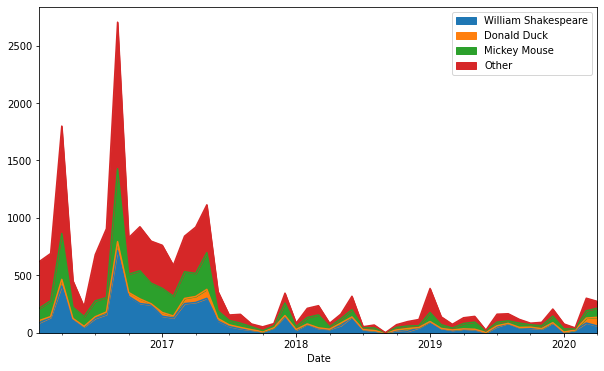

In [56]:
#make area plot
new_df.plot.area(stacked=True, figsize = (10,6))

### Pie chart of total messages by author

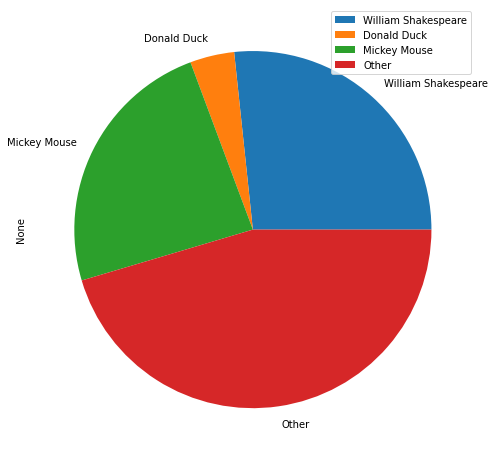

In [57]:
 import matplotlib

new_df.sum().plot.pie(legend=True, figsize = (8, 13)); #sums each column into a dataframe indexed by column title.


## The same plots, but with wordcount

In [58]:
#we'll create a new dataframe where each row is a time window from fast_group
wordcount_sum_df = pd.DataFrame({'Date': 
                            [date for date, group in fast_group]})

#create a list of counts for each name, add it to dataframe
names = {name for name in df.Author}
for name in names:
    counts = []
    for date in wordcount_sum_df['Date']: #iterate through dates assigned to each group
        subgroup = fast_group.get_group(date) #this date's group from the fast grouping we just did
        wordcount = subgroup[subgroup['Author']==name]['Wordcount'].sum() #sum nr of message words
        counts.append(wordcount)
    wordcount_sum_df[name] = counts #add the counts as a new column
    
wordcount_sum_df = wordcount_sum_df.set_index('Date')
wordcount_sum_df.head(2)



,William Shakespeare,Donald Duck,Mickey Mouse,Other
Date,,,,
2016-02-29,660,146,846,3039
2016-03-31,1005,62,1045,3116


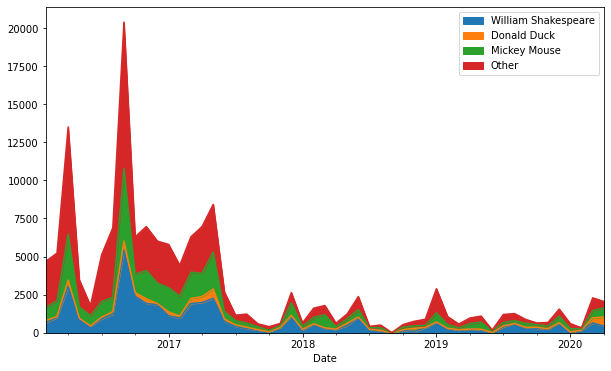

In [59]:
#graph
wordcount_sum_df.plot.area(stacked=True, figsize = (10, 6))

### Pie plot of words, not messages

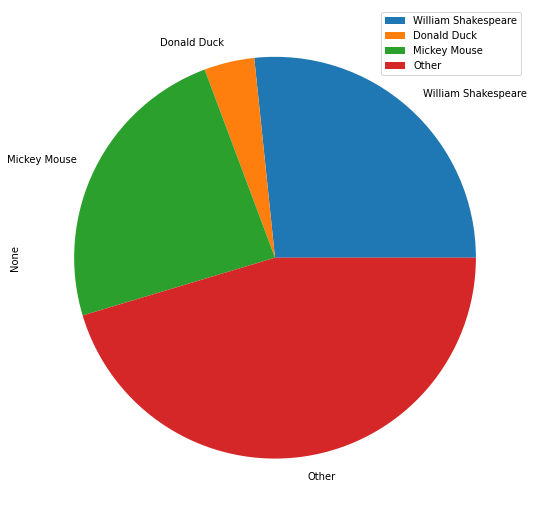

In [60]:
wordcount_sum_df.sum().plot.pie(legend=True, figsize = (9, 13)); #sums each column into a dataframe indexed by column title. Perfect!

# Graphing each author's wordcount as percentage of total, for each period

Find out who dominates each period in the history of the chat.

In [61]:
#create new dataframe and transpose

wordcount_percentage_df = wordcount_sum_df.transpose()

#divide each column by sum of that column
wordcount_percentage_df = 100*wordcount_percentage_df/wordcount_percentage_df.sum()

#transpose back
wordcount_percentage_df = wordcount_percentage_df.transpose()

#check
wordcount_percentage_df.head(1)

,William Shakespeare,Donald Duck,Mickey Mouse,Other
Date,,,,
2016-02-29,14.069495,3.112343,18.034534,64.783628


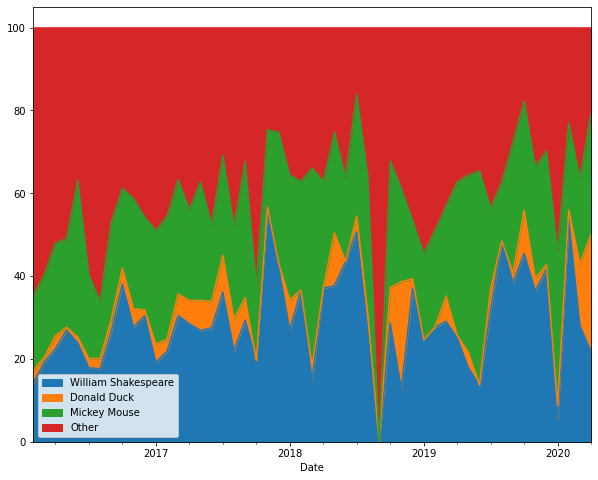

In [62]:
#graph
wordcount_percentage_df.plot.area(figsize = (10, 8))

# 4) Word Cloud

### Calculating word frequency

In [63]:
#create dictionary of word frequency 

from collections import Counter 

word_freq = Counter()

for tokenized in df['Tokenized']: #loop through the list of tokenized messages
    for token in tokenized:
        word_freq[token] += 1

In [64]:
#inspect the dictionary:
word_freq.most_common(4)

[('and', 6428), ('the', 5623), ('to', 4178), ('of', 3824)]

### Create a word cloud

Note that the word cloud package comes with a list of "stopwords", which are words like "and" and "can" that probably shouldn't be in the wordcloud. We can also add some of our own.

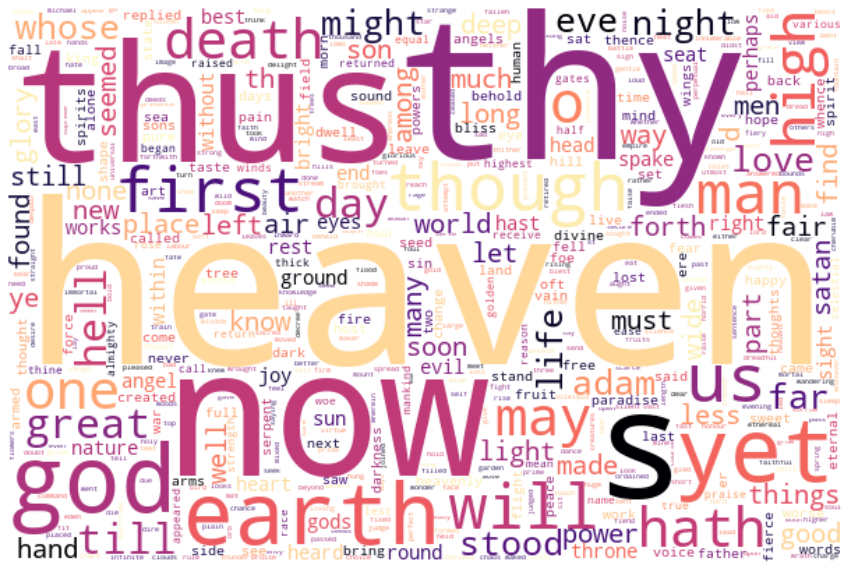

In [65]:
from wordcloud import WordCloud, STOPWORDS #stopwords has list of words to ignore -- very useful
from matplotlib import pyplot as plt

#ADD YOUR OWN STOPWORDS HERE:
custom_stopwords = ['thou', 'thee']

stopwords = set(STOPWORDS)

for word in custom_stopwords: 
    stopwords.add(word)


#Create a copy of the word frequency dictionary without the stopwords:

import copy
wordcloud_freq = copy.deepcopy(word_freq) #copy the counter dictionary

for word in word_freq.keys(): #iterate through entries of original dict
    if word in stopwords: #if word is a stopword
        del wordcloud_freq[word] #remove entry


#initiate word cloud object
facebook_wc = WordCloud(
    width = 600,
    height = 400,
    background_color='white',
    max_words=2000,
    stopwords=stopwords,
    colormap = 'magma'
)


#we can now generate the word cloud straight fom the worldcloud frequency counter above
facebook_wc.generate_from_frequencies(wordcloud_freq)

fig = plt.figure()
fig.set_figwidth(15) # set width
fig.set_figheight(12)

plt.imshow(facebook_wc, interpolation='bilinear')
plt.axis('off')
plt.show()


# 5) Basic sentiment analysis

Using the NLTK library's built in tools, we can do some basic sentiment analysis on the chat as well.


In [66]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer


**Need to run this only once:** this is so the sentiment analyzer knows what words are positive and negative:

In [67]:
nltk.download('vader_lexicon') #downloaded once, commented out not to repeat

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/macbook/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

### Score each author's sentiments

In [68]:
#Scoring each author -- takes like 30 seconds
from collections import defaultdict 

authorscores = defaultdict()
for author in set(df['Author']): #iterate through authors
    
    #need to get unified author string here
    authortext = " ".join( #join all members into a string
                        [" ".join(tokens) #join each token into its own string
                         for tokens in df[df['Author']==author]['Tokenized']]) 
                        #iterating through tokenized column for given author
    authorscores[author] = SentimentIntensityAnalyzer().polarity_scores(authortext) #now score this and add to dictionary

We can display the result in a dataframe:

In [69]:
sentiment_df = pd.DataFrame(authorscores)
sentiment_df

,William Shakespeare,Donald Duck,Mickey Mouse,Other
neg,0.136,0.1350,0.139,0.133
neu,0.669,0.6700,0.679,0.671
pos,0.194,0.1950,0.182,0.196
compound,1.000,0.9999,1.000,1.000


Graph positive vs. negative sentiments, author by author:

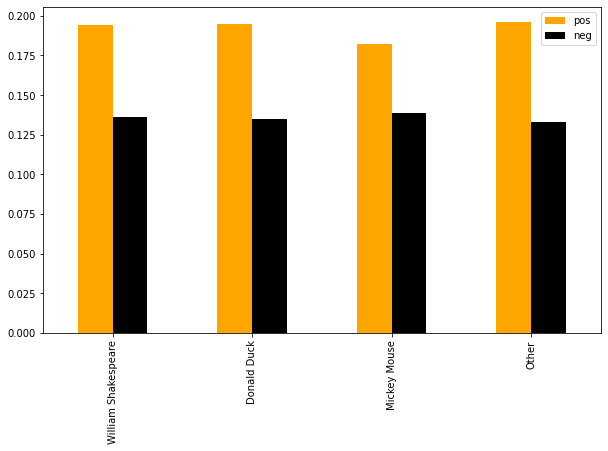

In [70]:
sentiment_df.transpose().plot.bar(y=['pos', 'neg'], color=['orange', 'black'], figsize=(10, 6))

# 6) Track sentiment over time...

Again, set a time interval that the data should be grouped into -- month by month? year by year? 2 weeks at at time?

This time, we add a new column to the messages dataframe, which says which time group that message belongs in.

This is a little annoying because we have to unify the tokenized messages for a given time period into a single long string of words--that's what the sentiment analyzer operates on.

### Set time binning frequency below:

In [71]:
sentiment_frequency = '1M' #see section 3 for possible options -- this affects the smoothness of our graph

In [72]:

timegroups = df.groupby([pd.Grouper(key='Date', freq=sentiment_frequency)]) #group dataframe by given time window
group_index = [] #this will be a new column that will say what time group each row of the dataframe belongs to

for index, group in timegroups: #go through each group
    group_index.extend([index]*group.shape[0]) #add that group's size amount of that group's time stamp to the new column

df = df.sort_values(by='Date', ascending=True)

#create a new column which shows which time group a given message is in
df['group'] = group_index

In [73]:
timescores = defaultdict()
for timegroup in set(df['group']): #iterate through time group names
    
    #need to get unified text string for this group
    grouptext = " ".join( #join all rows into a string
                        [" ".join(tokens) #join each token into its own string
                         for tokens in df[df['group']==timegroup]['Tokenized']]) #filter the dataframe to this time group only
                        #iterating through tokenized messages column for given year
    timescores[timegroup] = SentimentIntensityAnalyzer().polarity_scores(grouptext) #now score this and add to dictionary

timegroup_sentiment_df = pd.DataFrame(timescores).transpose()



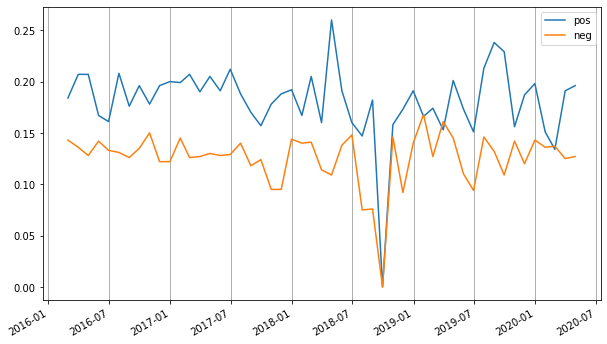

In [74]:
#graph
ax = timegroup_sentiment_df.plot(y=['pos', 'neg'], figsize = (10, 6))
ax.xaxis.grid(True, which='major', linestyle='-', linewidth=1)